# Importación de Librerías


In [0]:
#Importación de librerías
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import functions

In [0]:
#Lectura de datos
try:
  #Caso en que se esté usando jupyter notebooks o se encuentre los archivos de la data en el entorno de ejecución del notebook
  data_pulsar = pd.read_csv('HTRU_2_con_header.csv')
except:
  #Caso en que se use colab, y los archivos de la data estén en una carpeta del Drive
  dir_str ='drive/My Drive/CURSOS - MAESTRIA/APRENDIZAJE AUTOMÁTICO/MACHINE LEARNING - PROYECTO/ML_PULSAR_CLASSIFICATION_PROJECT/PREPROCESAMIENTO DE DATA/HTRU_2_sin_header.csv'
  #Se definen  los headers
  head = ['mean_IP', 'std_IP','kurt_IP','skew_IP','mean_DM', 'std_DM','kurt_DM','skew_DM','is_pulsar']
  #Lectura de la data
  data_pulsar = pd.read_csv(dir_str,header=None, names=head)


In [100]:
 data_pulsar.head()

,mean_IP,std_IP,kurt_IP,skew_IP,mean_DM,std_DM,kurt_DM,skew_DM,is_pulsar
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


# Normalización de la data

Ejecutamos la normalización del dataset.

In [101]:
head = ['mean_IP', 'std_IP','kurt_IP','skew_IP','mean_DM', 'std_DM','kurt_DM','skew_DM','is_pulsar']
scaler = MinMaxScaler()
scaler.fit(data_pulsar)
data_pulsar_scaled = pd.DataFrame(scaler.transform(data_pulsar), columns =head)
data_pulsar_scaled.describe()

,mean_IP,std_IP,kurt_IP,skew_IP,mean_DM,std_DM,kurt_DM,skew_DM,is_pulsar
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,0.563516,0.294263,0.236676,0.050966,0.055566,0.183555,0.303691,0.089553,0.091574
std,0.137325,0.092467,0.106987,0.088247,0.132059,0.188537,0.119591,0.089285,0.288432
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.509180,0.237869,0.191353,0.022939,0.007661,0.068430,0.236757,0.030962,0.000000
50%,0.584919,0.299640,0.211075,0.028480,0.011599,0.107395,0.307141,0.071285,0.000000
75%,0.649199,0.354712,0.236220,0.038912,0.023528,0.203905,0.367371,0.118432,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Realizamos la partición de la data de entrenamiento, validación y test.

In [0]:
#Partición de la data escalada
X_sca = data_pulsar_scaled.drop(columns=["is_pulsar"])
y_sca = data_pulsar_scaled["is_pulsar"]

X_trainval_sca, X_test_sca, y_trainval_sca, y_test_sca = train_test_split(X_sca, y_sca, test_size=0.15, random_state=2) #random_state = 0, para mantener la particion
X_train_sca, X_val_sca, y_train_sca, y_val_sca = train_test_split(X_trainval_sca, y_trainval_sca, test_size=0.2, random_state=0)


# Análisis de Algoritmos de Ensamble

## Algoritmo Base: SVM sobre data normalizada

El MSE para el modelo SVC es:  0.022674991784423268
El accuracy para el modelo SVC es:  0.9773250082155768
La precisión para el modelo SVC es:  0.9543147208121827
El recall para el modelo SVC es:  0.7580645161290323
El F1-score para el modelo SVC es:  0.844943820224719


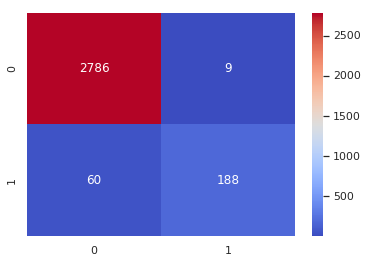

In [103]:
from sklearn.svm import SVC

SVM_model = SVC(gamma='auto',kernel='rbf')
SVM_model.fit(X_train_sca, y_train_sca)
functions.eval_model(SVM_model, X_val_sca, y_val_sca)

## Algoritmo Añadido: SVM sobre data normalizada y balanceada

In [0]:
#https://imbalanced-learn.readthedocs.io/en/latest/generated/imblearn.over_sampling.SVMSMOTE.html#r88acb9955f91-2
from imblearn.over_sampling import SVMSMOTE
smt = SVMSMOTE(random_state=12)
X_resampled, y_resampled = smt.fit_resample(X_train_sca, y_train_sca)
X_train_svmsmote = pd.DataFrame(X_resampled)
y_train_svmsmote = pd.Series(y_resampled)

In [105]:
print("* Antes del proceso de over-sampling, se tiene {} valores de la clase '1'".format(sum(y_train_sca==1)))
print("* Antes del proceso de over-sampling, se tiene {} valores de la clase '0'\n".format(sum(y_train_sca==0)))


print("* Después del proceso de over-sampling, se tiene {} valores de la clase '1'".format(sum(y_train_svmsmote==1)))
print("* Después del proceso de over-sampling, se tiene {} valores de la clase '0'".format(sum(y_train_svmsmote==0)))

* Antes del proceso de over-sampling, se tiene 1146 valores de la clase '1'
* Antes del proceso de over-sampling, se tiene 11024 valores de la clase '0'

* Después del proceso de over-sampling, se tiene 11024 valores de la clase '1'
* Después del proceso de over-sampling, se tiene 11024 valores de la clase '0'


El MSE para el modelo SVC es:  0.03647716069668091
El accuracy para el modelo SVC es:  0.9635228393033191
La precisión para el modelo SVC es:  0.7120743034055728
El recall para el modelo SVC es:  0.9274193548387096
El F1-score para el modelo SVC es:  0.8056042031523643


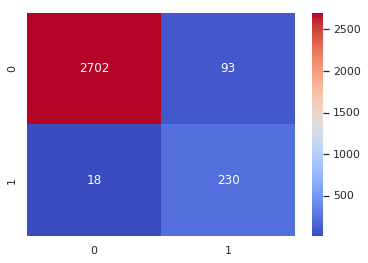

In [106]:
from sklearn.svm import SVC

SVM_model_sm = SVC(C=100,gamma='auto',kernel='rbf')
SVM_model_sm.fit(X_train_svmsmote, y_train_svmsmote)
functions.eval_model(SVM_model_sm, X_val_sca, y_val_sca)

## Ensamble


In [107]:
y_val_predict_base = SVM_model.predict(X_val_sca)
pd.Series(y_val_predict_base).value_counts()


0.0    2846
1.0     197
dtype: int64

In [0]:
X_val_predict1 =[]
indexes=[]
for i in range(len(y_val_predict1)):
  if y_val_predict_base[i]==0:
    X_val_predict1.append(X_val_sca.iloc[i,:])
    indexes.append(i)

In [0]:
y_val_predict_addin = SVM_model_sm.predict(X_val_predict1)
for j in range(len(y_val_predict_addin)):
  y_val_predict_base[indexes[j]] = y_val_predict_addin[j]

Error MSE:  0.03647716069668091


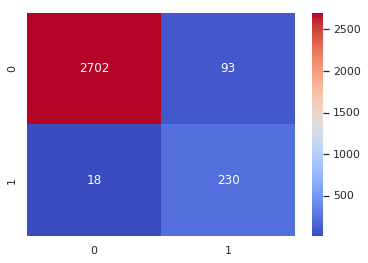

In [113]:
from sklearn.metrics import mean_squared_error
NN_model_mse = mean_squared_error(y_val_sca, y_val_predict_base)  
print("Error MSE: ",NN_model_mse)

from sklearn.metrics import confusion_matrix
NN_model_cm = confusion_matrix(y_val_sca, y_val_predict_base)  

sns.heatmap(NN_model_cm,annot=True, fmt="d", cmap="coolwarm");